In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
plt.style.use('seaborn-pastel')
sns.set_style("whitegrid")

import warnings #출력문제로 나타나는 경고 무시
warnings.filterwarnings("ignore")

#한글 시각화
import matplotlib
from matplotlib import font_manager, rc


font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False

#  데이터 Load
###### 사용 데이터셋
1. 전국교통 안전지수데이터(시군구)
2. 사고데이터
3. 도로링크데이터


In [3]:
전국교통안전지수 = pd.read_excel('data/전국교통안전지수+차량수+도로길이_final.xlsx', encoding = 'EUC-KR', index_col = 0)
전국사고데이터 = pd.read_csv('data/전국사고_시군구전처리229개.csv', engine ='python', encoding = 'utf-8', index_col = 0)
전국링크데이터 = pd.read_csv('data/전국링크데이터.csv', index_col = 0)

전국교통안전지수.tail()

# 227개의 지자체 + (울릉군+옹진군) 을 임의로 추가해줘서 229개의 지자체가 됨

,SIG_CD,SIG_ENG_NM,시군구,구분,최종점수,전체등급,교통약자,교통약자등급,운전자,운전자 등급,도로환경,도로환경 등급,자동차등록대수,도로길이
224,48870,Hamyang-gun,함양군,경남,81.72,C,80.99,C,80.35,C,81.31,D,19740,563.207
225,48880,Geochang-gun,거창군,경남,82.82,C,82.73,C,83.92,B,83.81,C,107282,576.253
226,48890,Hapcheon-gun,합천군,경남,82.31,C,82.76,C,83.14,B,84.88,B,23812,663.370
227,50110,Jeju-si,제주시,제주,74.58,C,73.74,C,77.76,B,70.42,C,59569,1496.743
228,50130,Seogwipo-si,서귀포시,제주,72.28,E,72.31,D,70.83,E,61.28,E,73285,1257.721


# 1. 전국교통안전지수 EDA

In [4]:
def 상위10하위10전국그래프(df, column):
    
    Top10 = df.sort_values(by = column , ascending=False)[['시군구',column]][:10]  #상위10개
    Bot10 = df.sort_values(by = column, ascending=False)[['시군구',column]][-10:]  #하위10개
    Top10_Bot10 = Top10.append(Bot10, ignore_index = True) #
    
    plt.figure(figsize = (18,4))

    plt.title('상위10개, 하위 10개 시군구의 전국' + column + ' 지수', fontweight="bold") 

    plt.axhline(df[column].mean(), color = 'purple' , linestyle='--') # 지수 평균 수평선
    plt.axvline(9.5, linewidth = 5 , ls = '--')   #상위10위, 하위10위 구분 경계선


    xs = Top10_Bot10['시군구'].values              # x축
    ys = Top10_Bot10[column].values                # y축

    ax = sns.barplot(x = xs, y = ys )
    
    
    if '청주시' in str(Top10_Bot10['시군구'].values):                     #만약 상위또는 하위10위에 청주시 존재한다면
        L = Top10_Bot10[Top10_Bot10['시군구']=='청주시'].index[0] - 0.5   #청주시를 빨간네모박스로 강조 시각화
        RedBox_height = (Top10_Bot10[Top10_Bot10['시군구']=='청주시'][column].values[0])

        rect = patches.Rectangle((L , 4),1, RedBox_height  ,linewidth=2.5 ,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    plt.show()

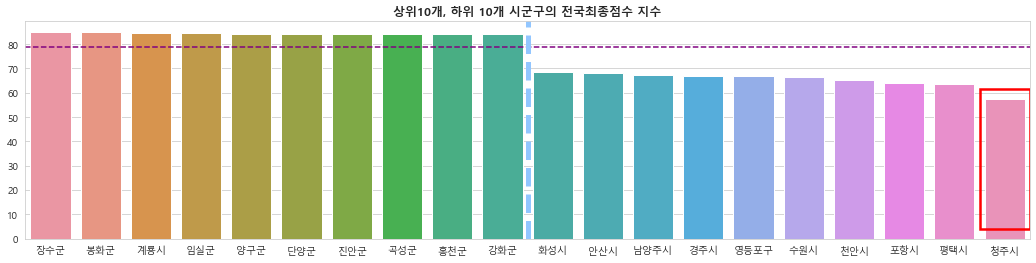

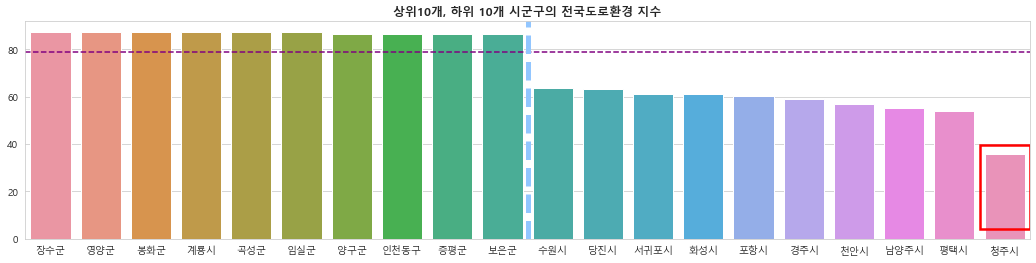

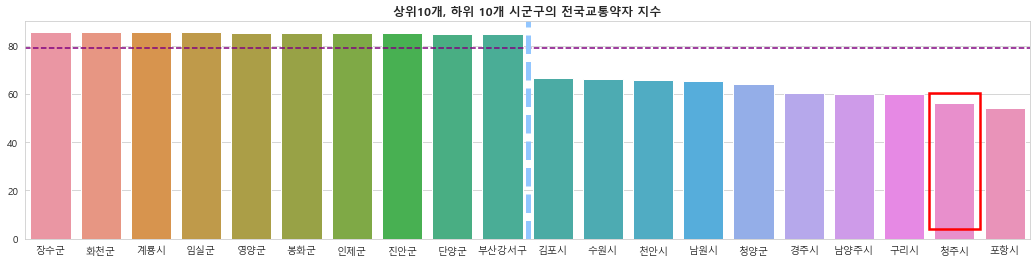

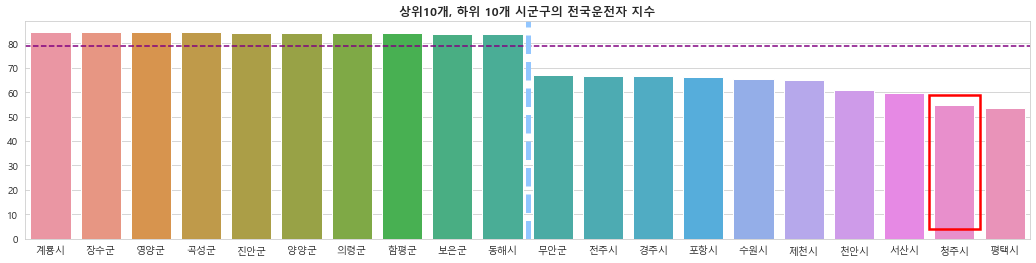

In [5]:
상위10하위10전국그래프(df = 전국교통안전지수 , column = '최종점수')
상위10하위10전국그래프(df = 전국교통안전지수 , column = '도로환경')
상위10하위10전국그래프(df = 전국교통안전지수 , column = '교통약자')
상위10하위10전국그래프(df = 전국교통안전지수 , column = '운전자')

- 청주시의 __교통안전지수__도 227개 시군구 중 가장 최하위(227위)이고, 그 중 __도로환경지수__가 상당히 낮음을 볼 수 있다.

# 1. 사고 분석
1. SCLAS (사고 차량 유형)
2. LCLAS (사고 크기 유형)
3. 요일데이터

In [6]:
전국사고데이터['SCLAS'].value_counts()

차대차     484044
차대사람    140456
차량단독     29847
Name: SCLAS, dtype: int64

##### 철길건널목과 건널목에 대한 데이터는 비교적 상당히 적으므로 제거
- 건널목이나 , 철길건널목에서 일어난 사고는 모두 제외

In [7]:
전국사고데이터 = 전국사고데이터[(전국사고데이터['SCLAS'] != '건널목') & (전국사고데이터['SCLAS'] !='철길건널목')]
전국사고데이터.head()

,OBJT_ID,OCCU_YEAR,OCCU_MT,OCCU_DE,OCCU_TM,OCCU_DAY,OCCU_DATE,LCLAS,SCLAS,DEATH,...,DRNKG,KID,ODSN,WLKG,VIOLT_CN,CTPRVN_CD,SIG_CD,EMD_CD,X,Y
0,1,2016,2,27,16,토요일,20160227,경상사고,차대차,0,...,0,0,0,0,안전거리 미확보,11,11110,11110101,1.413422e+07,4.521789e+06
1,2,2016,2,28,19,일요일,20160228,중상사고,차대차,0,...,0,0,0,0,안전운전 의무 불이행,11,11110,11110101,1.413420e+07,4.521219e+06
2,3,2016,3,28,7,월요일,20160328,중상사고,차대차,0,...,0,0,0,0,안전거리 미확보,11,11110,11110101,1.413455e+07,4.521176e+06
3,4,2016,4,5,13,화요일,20160405,경상사고,차대차,0,...,0,0,1,0,안전운전 의무 불이행,11,11110,11110101,1.413401e+07,4.521163e+06
4,5,2016,5,15,19,일요일,20160515,경상사고,차대차,0,...,0,1,0,0,안전거리 미확보,11,11110,11110101,1.413422e+07,4.521177e+06


##### 1. 전국 사고데이터에서 청주데이터 분리
- 청주시 SGG : 43110

In [8]:
##### 1. 전국 사고데이터에서 청주데이터 분리
청주시사고데이터 = 전국사고데이터[전국사고데이터['SIG_CD'] == 43110]
청주시사고데이터

,OBJT_ID,OCCU_YEAR,OCCU_MT,OCCU_DE,OCCU_TM,OCCU_DAY,OCCU_DATE,LCLAS,SCLAS,DEATH,...,DRNKG,KID,ODSN,WLKG,VIOLT_CN,CTPRVN_CD,SIG_CD,EMD_CD,X,Y
456202,456203,2016,1,28,22,목요일,20160128,중상사고,차대사람,0,...,0,0,0,1,기타,43,43110,43111101,1.419145e+07,4.388559e+06
456203,456204,2016,1,30,20,토요일,20160130,중상사고,차대사람,0,...,0,0,0,1,안전운전 의무 불이행,43,43110,43111101,1.419171e+07,4.388591e+06
456204,456205,2016,2,5,7,금요일,20160205,경상사고,차대차,0,...,0,0,0,0,신호위반,43,43110,43111101,1.419119e+07,4.389651e+06
456205,456206,2016,3,21,15,월요일,20160321,부상신고사고,차대차,0,...,0,0,0,0,안전운전 의무 불이행,43,43110,43111101,1.419152e+07,4.388825e+06
456206,456207,2016,4,7,15,목요일,20160407,경상사고,차대사람,0,...,0,0,0,1,안전운전 의무 불이행,43,43110,43111101,1.419185e+07,4.388211e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471081,471082,2018,11,27,20,화요일,20181127,중상사고,차대사람,0,...,0,0,0,1,안전운전 의무 불이행,43,43110,43114310,1.419853e+07,4.404584e+06
471082,471083,2018,12,6,18,목요일,20181206,경상사고,차대차,0,...,0,0,0,0,안전운전 의무 불이행,43,43110,43114310,1.419719e+07,4.402684e+06
471083,471084,2018,12,7,18,금요일,20181207,경상사고,차대차,0,...,0,0,1,0,기타,43,43110,43114310,1.419443e+07,4.406616e+06
471084,471085,2018,12,23,10,일요일,20181223,중상사고,차대차,0,...,0,0,0,0,신호위반,43,43110,43114310,1.419792e+07,4.402590e+06


In [9]:
청주시사고데이터.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14883 entries, 456202 to 471085
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   OBJT_ID    14883 non-null  int64  
 1   OCCU_YEAR  14883 non-null  int64  
 2   OCCU_MT    14883 non-null  int64  
 3   OCCU_DE    14883 non-null  int64  
 4   OCCU_TM    14883 non-null  int64  
 5   OCCU_DAY   14883 non-null  object 
 6   OCCU_DATE  14883 non-null  int64  
 7   LCLAS      14883 non-null  object 
 8   SCLAS      14883 non-null  object 
 9   DEATH      14883 non-null  int64  
 10  SWPSN      14883 non-null  int64  
 11  SINJPSN    14883 non-null  int64  
 12  INJPSN     14883 non-null  int64  
 13  DRNKG      14883 non-null  int64  
 14  KID        14883 non-null  int64  
 15  ODSN       14883 non-null  int64  
 16  WLKG       14883 non-null  int64  
 17  VIOLT_CN   14883 non-null  object 
 18  CTPRVN_CD  14883 non-null  int64  
 19  SIG_CD     14883 non-null  int64  
 20  

# 청주시와 전국 사고데이터 비교
- 사고 유형
- 사고 차량 유형
- 요일별 비교
- 월별 비교

In [10]:
def 비교시각화(column):
    
    df = pd.DataFrame({'청주시' : 청주시사고데이터[column].value_counts(normalize = True),
                       '전국' : 전국사고데이터[column].value_counts(normalize = True)})
    
    ax = df.plot(kind = 'bar', figsize = (15,4))
    ax.set_title(column, fontsize = 25, fontweight="bold")

    plt.xticks(rotation = 0)
    for p in ax.patches:

        height = p.get_height()

        ax.text(x = p.get_x()+p.get_width()/2., 
                y = height,
                s = str(np.round(height*100,1)) + '%' 
                ,ha="center",fontsize=12)
    plt.show()

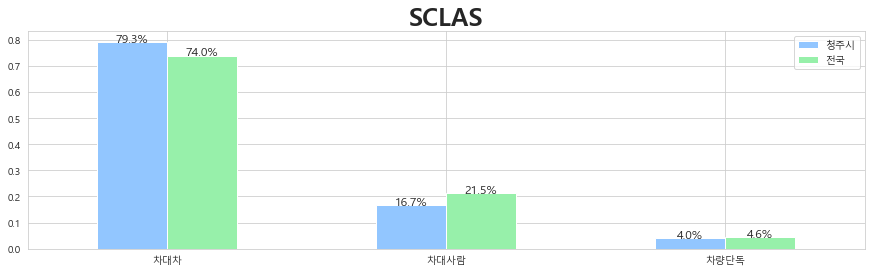

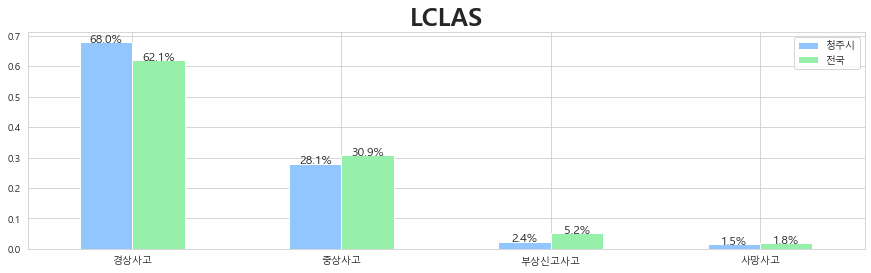

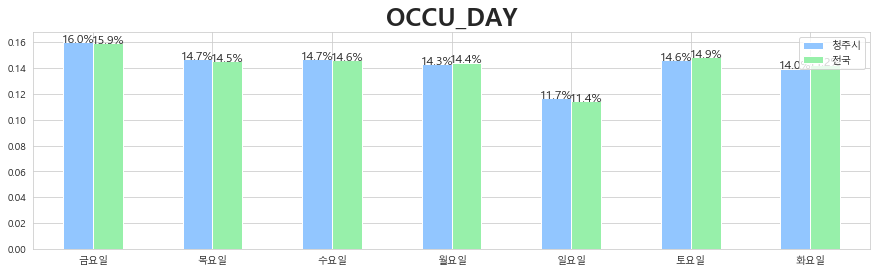

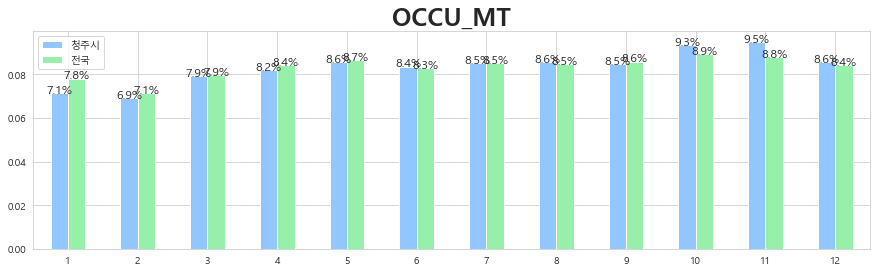

In [11]:
비교시각화('SCLAS')
비교시각화('LCLAS')
비교시각화('OCCU_DAY')
비교시각화('OCCU_MT')

In [12]:
전국사고데이터.columns

Index(['OBJT_ID', 'OCCU_YEAR', 'OCCU_MT', 'OCCU_DE', 'OCCU_TM', 'OCCU_DAY',
       'OCCU_DATE', 'LCLAS', 'SCLAS', 'DEATH', 'SWPSN', 'SINJPSN', 'INJPSN',
       'DRNKG', 'KID', 'ODSN', 'WLKG', 'VIOLT_CN', 'CTPRVN_CD', 'SIG_CD',
       'EMD_CD', 'X', 'Y'],
      dtype='object')

# 사고데이터 시군구별로 분석

In [13]:
지역별사고데이터 = 전국사고데이터.groupby('SIG_CD').count().iloc[:,0].reset_index()
지역별사고데이터 = pd.merge(지역별사고데이터 , 전국교통안전지수[['SIG_CD','시군구']] , on = 'SIG_CD')
지역별사고데이터 = 지역별사고데이터.rename(columns = {'OBJT_ID' : '사고건수'})
지역별사고데이터 = 지역별사고데이터.sort_values(by = '사고건수')
지역별사고데이터

,SIG_CD,사고건수,시군구
208,47940,57,울릉군
58,28720,108,옹진군
159,45740,175,장수군
157,45720,210,진안군
141,44250,224,계룡시
...,...,...,...
84,41280,11185,고양시
76,41130,11316,성남시
83,41270,11358,안산시
124,43110,14883,청주시


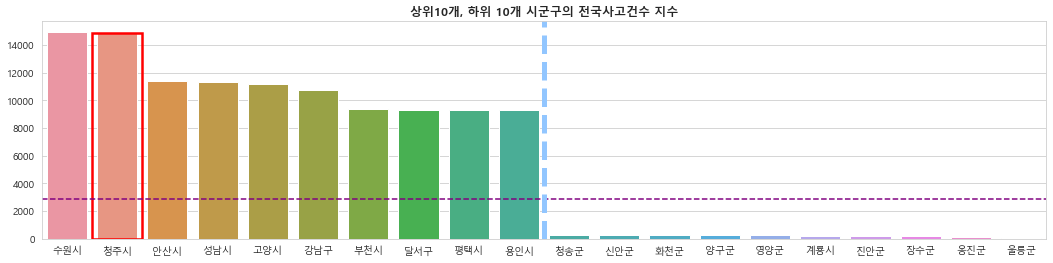

In [14]:
상위10하위10전국그래프(df = 지역별사고데이터 , column = '사고건수')

>- 사고건수가 청주시가 전국 지자체 사고 2위인것을 볼 수 있다.
>- 도로가 많고 , 차량이 많다면 그에 비례할 수 있으므로 , 도로길이와 면허소지량을 고려

In [15]:
시도별사고merge_df = 지역별사고데이터.merge(전국교통안전지수[['SIG_CD','자동차등록대수','도로길이']], on = 'SIG_CD')
시도별사고merge_df

,SIG_CD,사고건수,시군구,자동차등록대수,도로길이
0,47940,57,울릉군,144768,47.881
1,28720,108,옹진군,106991,42.505
2,45740,175,장수군,57873,463.445
3,45720,210,진안군,14243,531.863
4,44250,224,계룡시,22235,93.140
...,...,...,...,...,...
224,41280,11185,고양시,220459,925.500
225,41130,11316,성남시,400042,742.890
226,41270,11358,안산시,252964,685.387
227,43110,14883,청주시,429462,1791.957


In [16]:
시도별사고merge_df['사고건수/도로길이'] = 시도별사고merge_df['사고건수']/시도별사고merge_df['도로길이']
시도별사고merge_df['사고건수/자동차등록대수'] = 시도별사고merge_df['사고건수']/시도별사고merge_df['자동차등록대수']

시도별사고merge_df.tail()

,SIG_CD,사고건수,시군구,자동차등록대수,도로길이,사고건수/도로길이,사고건수/자동차등록대수
224,41280,11185,고양시,220459,925.500,12.085359,0.050735
225,41130,11316,성남시,400042,742.890,15.232403,0.028287
226,41270,11358,안산시,252964,685.387,16.571660,0.044900
227,43110,14883,청주시,429462,1791.957,8.305445,0.034655
228,41110,14960,수원시,659173,710.746,21.048307,0.022695


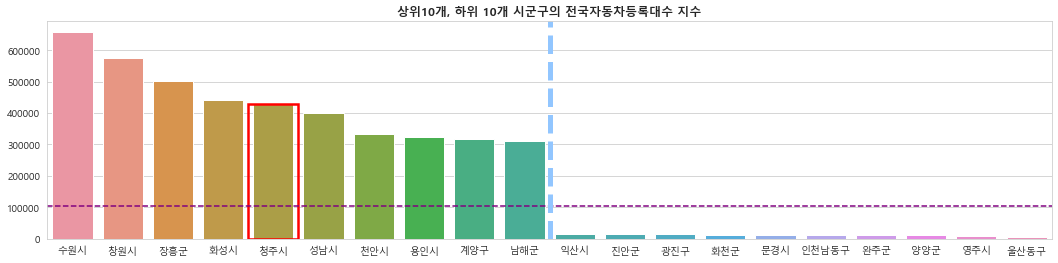

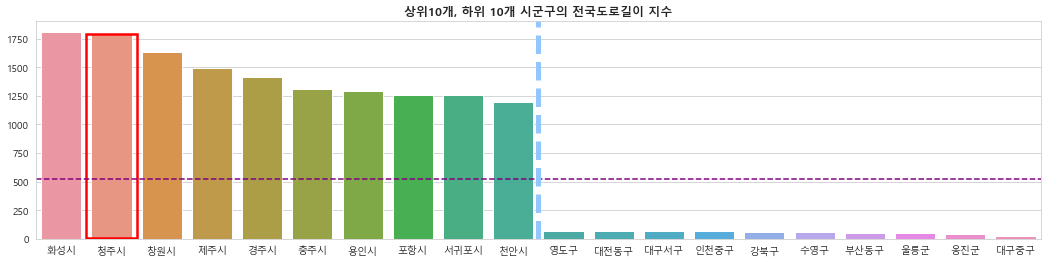

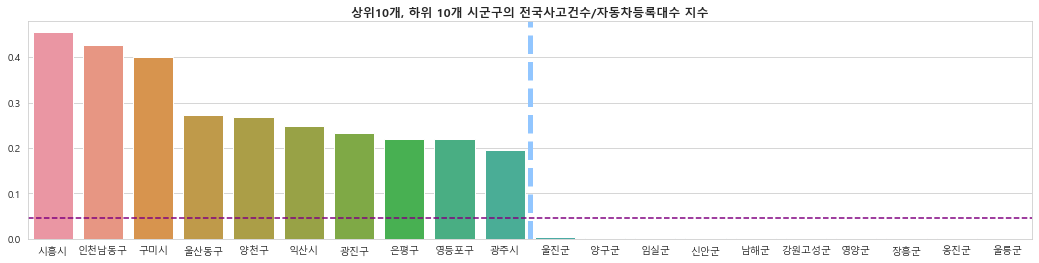

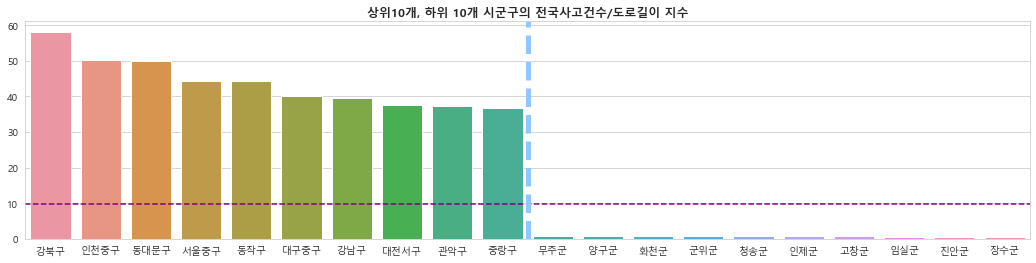

In [17]:
상위10하위10전국그래프(df = 시도별사고merge_df, column = '자동차등록대수')
상위10하위10전국그래프(df = 시도별사고merge_df, column = '도로길이')
상위10하위10전국그래프(df = 시도별사고merge_df, column = '사고건수/자동차등록대수')
상위10하위10전국그래프(df = 시도별사고merge_df, column = '사고건수/도로길이')


#지워야될듯,,, 청주의 심각성이 전혀 안보임

>- 자동차등록대수가 상당히 많음
>- 도로길이도 상당히 김 (__노드링크체계__에서 링크 length 시군구코드 활용해서 sum)

In [18]:
교통사고피해 = 전국사고데이터.groupby('SIG_CD').sum().loc[:,'DEATH':'INJPSN'].reset_index()
교통사고피해 = 교통사고피해.merge(전국교통안전지수[['SIG_CD','시군구']] , on = 'SIG_CD')
교통사고피해

,SIG_CD,DEATH,SWPSN,SINJPSN,INJPSN,시군구
0,11110,28,1096,3287,600,종로구
1,11140,30,1256,3113,537,서울중구
2,11170,38,1264,4193,413,용산구
3,11200,39,1081,3002,520,성동구
4,11215,35,1101,2985,295,광진구
...,...,...,...,...,...,...
224,48870,29,314,375,118,함양군
225,48880,35,517,465,33,거창군
226,48890,35,308,356,44,합천군
227,50110,135,2839,9455,1589,제주시


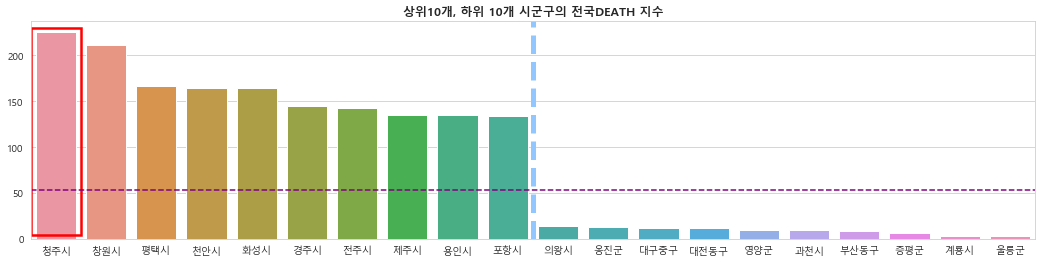

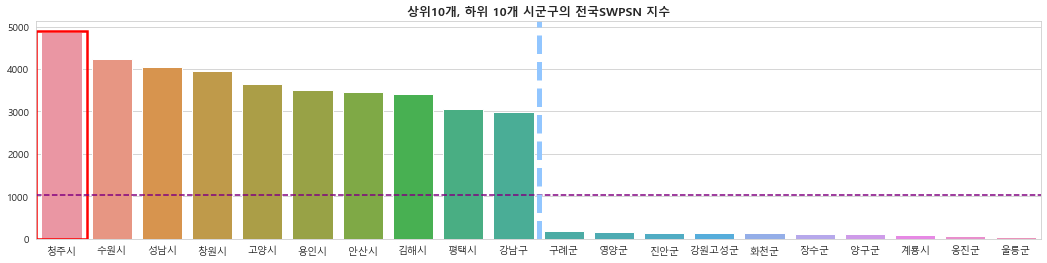

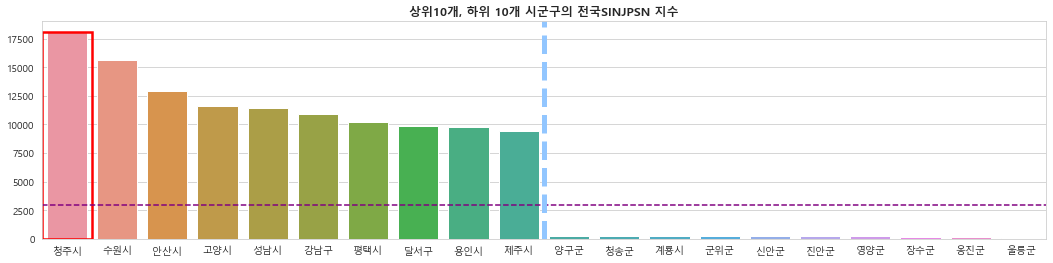

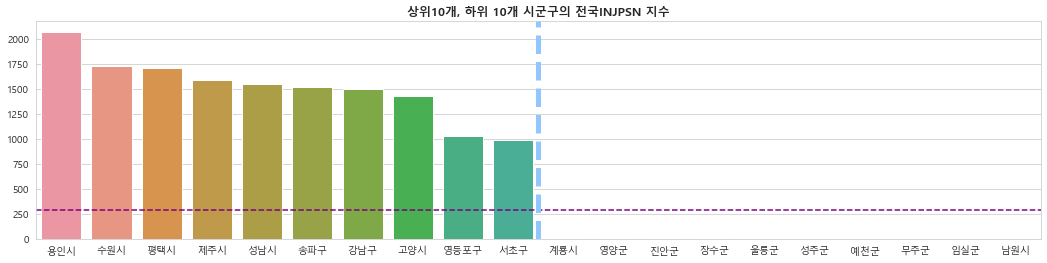

In [19]:
상위10하위10전국그래프(df = 교통사고피해, column = 'DEATH')
상위10하위10전국그래프(df = 교통사고피해, column = 'SWPSN')
상위10하위10전국그래프(df = 교통사고피해, column = 'SINJPSN')
상위10하위10전국그래프(df = 교통사고피해, column = 'INJPSN')


>- 청주시가 사망자나 중상자가 상당히 많은것을 볼 수 있음

In [20]:
전국사고데이터.groupby('SIG_CD').sum()

,OBJT_ID,OCCU_YEAR,OCCU_MT,OCCU_DE,OCCU_TM,OCCU_DATE,DEATH,SWPSN,SINJPSN,INJPSN,DRNKG,KID,ODSN,WLKG,CTPRVN_CD,EMD_CD,X,Y
SIG_CD,,,,,,,,,,,,,,,,,,
11110,6564876,7307426,23611,57097,46914,73076678197,28,1096,3287,600,210,97,556,1068,39853,40252083383,5.121695e+10,1.637539e+10
11140,20018110,7398196,23977,58515,47596,73984416215,30,1256,3113,537,160,79,459,960,40348,40862030665,5.185381e+10,1.657048e+10
11170,38243205,8259517,27446,64778,51923,82597979378,38,1264,4193,413,324,125,500,896,45045,45741659068,5.788507e+10,1.848343e+10
11200,43284969,6692450,21902,52952,43165,66926743152,39,1081,3002,520,244,119,458,805,36498,37161967559,4.692306e+10,1.498556e+10
11215,52478921,6488752,20989,51161,40914,64889670061,35,1101,2985,295,288,159,392,861,35387,36078990531,4.550938e+10,1.452625e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48870,343539843,1083102,3535,8346,7077,10831381846,29,314,375,118,57,23,226,93,25776,26243351920,7.636043e+09,2.275916e+09
48880,487976037,1536932,5151,12222,10580,15369847322,35,517,465,33,70,50,256,129,36576,37246772040,1.085042e+10,3.244973e+09
48890,345520021,1087151,3685,8344,7317,10871886844,35,308,356,44,39,17,240,97,25872,26351896990,7.690185e+09,2.286430e+09


In [21]:
교통사고특이유형 = 전국사고데이터.groupby('SIG_CD').sum().loc[:,'DRNKG':'WLKG'].reset_index()
교통사고특이유형 = 교통사고특이유형.merge(전국교통안전지수[['SIG_CD','시군구']] , on = 'SIG_CD')
교통사고특이유형

,SIG_CD,DRNKG,KID,ODSN,WLKG,시군구
0,11110,210,97,556,1068,종로구
1,11140,160,79,459,960,서울중구
2,11170,324,125,500,896,용산구
3,11200,244,119,458,805,성동구
4,11215,288,159,392,861,광진구
...,...,...,...,...,...,...
224,48870,57,23,226,93,함양군
225,48880,70,50,256,129,거창군
226,48890,39,17,240,97,합천군
227,50110,658,723,1359,2227,제주시


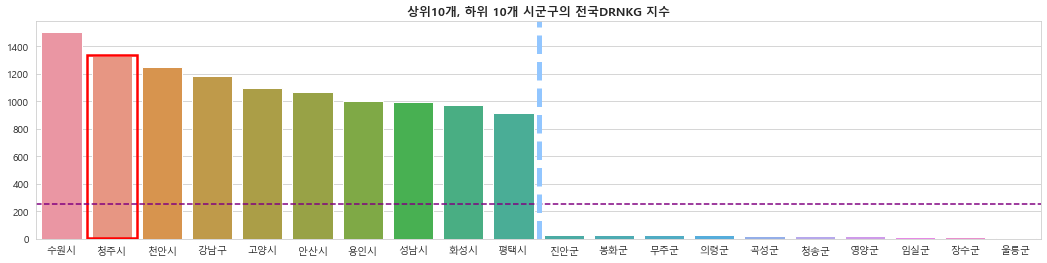

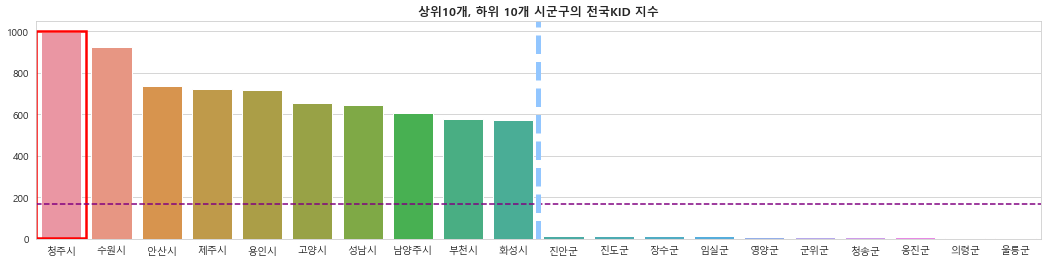

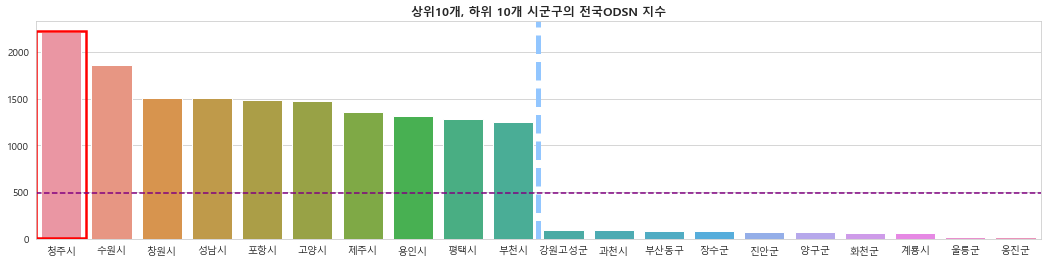

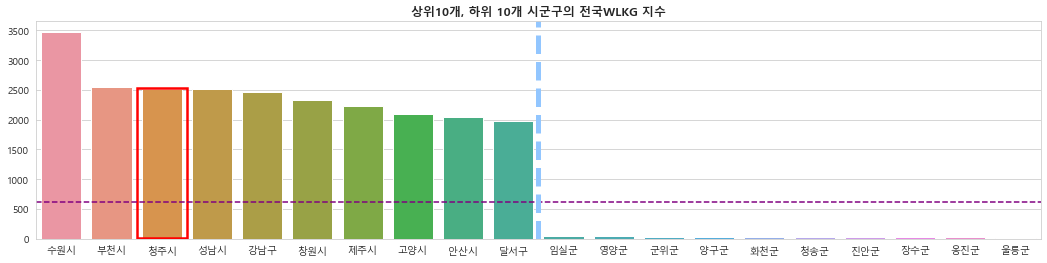

In [22]:
상위10하위10전국그래프(df = 교통사고특이유형, column = 'DRNKG')
상위10하위10전국그래프(df = 교통사고특이유형, column = 'KID')
상위10하위10전국그래프(df = 교통사고특이유형, column = 'ODSN')
상위10하위10전국그래프(df = 교통사고특이유형, column = 'WLKG')


# 전국링크데이터 분석

In [23]:
전국링크데이터['sigungu_id'].value_counts()

31240    10555
39010     8623
39020     7257
38070     6957
31070     6565
         ...  
23020      458
21020      439
21010      235
23320      176
37430      137
Name: sigungu_id, Length: 250, dtype: int64

In [24]:
전국링크데이터.head()

,link_id,up_f_node,up_t_node,dw_f_node,dw_t_node,max_speed,road_name,road_no,road_rank,link_type,...,RC_ID,RC_Name,RC_hist,RC_date,RC_length,old_link_i,source,rc_desc,rc_apply,geometry
0,338700014,692901,692903,692903,692901,0,자은서부2길,0,107,32768,...,NaN,NaN,410,NaN,NaN,0.0,2,반영대상_섬지역,2.0,LINESTRING (861417.2248183173 1653915.22844578...
1,338700016,693771,692903,692903,693771,0,자은서부2길,0,107,32768,...,NaN,NaN,410,NaN,NaN,0.0,2,반영대상_섬지역,1.0,LINESTRING (862761.5734449785 1654322.86909959...
2,338700018,692904,692906,692906,692904,0,자은서부2길,0,107,32768,...,NaN,NaN,410,NaN,NaN,0.0,2,반영대상_섬지역,2.0,LINESTRING (862522.4235445805 1654931.12459658...
3,338700019,693771,692906,692906,693771,0,자은서부2길,0,107,32768,...,NaN,NaN,410,NaN,NaN,0.0,2,반영대상_섬지역,1.0,LINESTRING (862761.5734449785 1654322.86909959...
4,412300044,100923,100185,100185,100923,50,대한로140번길,0,107,32768,...,NaN,NaN,0,NaN,NaN,0.0,0,NaN,0.0,LINESTRING (883360.8783109759 1472729.33895094...


# 아래는 다 삭제

In [ ]:
list(전국사고데이터['SGG_CD'].value_counts().sort_index().index)

In [ ]:
전국사고데이터['SGG_CD'] = 전국사고데이터['SGG_CD'].astype(str)

#####  수원4개

In [ ]:
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '41111' , 'SGG_CD'] = '41110'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '41113' , 'SGG_CD'] = '41110'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '41115' , 'SGG_CD'] = '41110'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '41117' , 'SGG_CD'] = '41110'

##### 성남3개

In [ ]:
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '41131' , 'SGG_CD'] = '41130'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '41133' , 'SGG_CD'] = '41130'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '41135' , 'SGG_CD'] = '41130'

##### 안산2개

In [ ]:
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '41271' , 'SGG_CD'] = '41270'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '41273' , 'SGG_CD'] = '41270'

##### 고양시3개

In [ ]:
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '41281' , 'SGG_CD'] = '41280'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '41285' , 'SGG_CD'] = '41280'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '41287' , 'SGG_CD'] = '41280'

##### 용인시 3개

In [ ]:
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '41461' , 'SGG_CD'] = '41463'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '41465' , 'SGG_CD'] = '41463'
# 세개 잘 들어간거임..

##### 청주시 4개

In [ ]:
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '43111' , 'SGG_CD'] = '43110'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '43112' , 'SGG_CD'] = '43110'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '43113' , 'SGG_CD'] = '43110'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '43114' , 'SGG_CD'] = '43110'

##### 천안시 2개

In [ ]:
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '44133' , 'SGG_CD'] = '44131'
#천안시 2개 잘된거임

전주시 2개

In [ ]:
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '45111' , 'SGG_CD'] = '45110'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '45113' , 'SGG_CD'] = '45110'


##### 포항시 2개

In [ ]:
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '47111' , 'SGG_CD'] = '47110'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '47113' , 'SGG_CD'] = '47110'


##### 창원시 5개

In [ ]:
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '48121' , 'SGG_CD'] = '48125'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '48123' , 'SGG_CD'] = '48125'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '48127' , 'SGG_CD'] = '48125'
전국사고데이터.loc[전국사고데이터['SGG_CD'] == '48129' , 'SGG_CD'] = '48125'
#5개 잘 됨

##### 안양시 2개

In [ ]:
전국사고데이터.loc[전국사고데이터['SIG_CD'] == '41171' , 'SIG_CD'] = '41170'
전국사고데이터.loc[전국사고데이터['SIG_CD'] == '41173' , 'SIG_CD'] = '41170'

#전국사고데이터.loc[전국사고데이터['SIG_CD'] == '41171' , 'SGG_CD'] = '41170'
#전국사고데이터.loc[전국사고데이터['SIG_CD'] == '41173' , 'SGG_CD'] = '41170'


In [ ]:
전국사고데이터['SIG_CD'] = 전국사고데이터['SIG_CD'].astype(str)

In [ ]:
전국사고데이터[전국사고데이터['SIG_CD'] == '41170']

In [ ]:
list(전국사고데이터['SIG_CD'].value_counts().sort_index().index)

In [ ]:
전국사고데이터

In [ ]:
전국사고데이터.loc[전국사고데이터['SIG_CD'] == 41171 , :]

In [21]:
전국사고데이터.to_csv('data/전국사고_시군구전처리230개.csv')

In [20]:
전국사고데이터

,OBJT_ID,OCCU_YEAR,OCCU_MT,OCCU_DE,OCCU_TM,OCCU_DAY,OCCU_DATE,LCLAS,SCLAS,DEATH,...,DRNKG,KID,ODSN,WLKG,VIOLT_CN,CTPRVN_CD,SIG_CD,EMD_CD,X,Y
0,1,2016,2,27,16,토요일,20160227,경상사고,차대차,0,...,0,0,0,0,안전거리 미확보,11,11110,11110101,1.413422e+07,4.521789e+06
1,2,2016,2,28,19,일요일,20160228,중상사고,차대차,0,...,0,0,0,0,안전운전 의무 불이행,11,11110,11110101,1.413420e+07,4.521219e+06
2,3,2016,3,28,7,월요일,20160328,중상사고,차대차,0,...,0,0,0,0,안전거리 미확보,11,11110,11110101,1.413455e+07,4.521176e+06
3,4,2016,4,5,13,화요일,20160405,경상사고,차대차,0,...,0,0,1,0,안전운전 의무 불이행,11,11110,11110101,1.413401e+07,4.521163e+06
4,5,2016,5,15,19,일요일,20160515,경상사고,차대차,0,...,0,1,0,0,안전거리 미확보,11,11110,11110101,1.413422e+07,4.521177e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654354,654355,2018,12,15,16,토요일,20181215,경상사고,차대차,0,...,0,0,0,0,신호위반,50,50130,50130320,1.411856e+07,3.939567e+06
654355,654356,2018,12,15,23,토요일,20181215,경상사고,차대차,0,...,0,0,1,0,신호위반,50,50130,50130320,1.411837e+07,3.940935e+06
654356,654357,2018,12,18,18,화요일,20181218,중상사고,차대차,0,...,0,0,0,0,안전운전 의무 불이행,50,50130,50130320,1.411768e+07,3.938694e+06
654357,654358,2018,12,21,11,금요일,20181221,중상사고,차대사람,0,...,0,0,1,1,중앙선 침범,50,50130,50130320,1.411887e+07,3.938561e+06


# PRAC


In [ ]:
전국교통안전지수[전국교통안전지수['시군구'].str.contains('안양시')]

# 연습장

수원시 (41110)
- 고양시 덕양구
- 고양시 일산동구
- 고양시 일산서구


In [43]:
전국교통안전지수[['SIG_CD','시군구']].to_excel('시군구_옛날_현재_SIG_CD.xlsx')

In [ ]:
전국사고데이터.to_csv('data/전국사고_시군구전처리230개.csv')

In [46]:
zzzz = pd.read_csv('data/sig코드변환용csv.csv')
zzzz

,신SIG_CD,구SIG_CD,시군구
0,11110,11010,종로구
1,11140,11020,서울중구
2,11170,11030,용산구
3,11200,11040,성동구
4,11215,11050,광진구
...,...,...,...
245,48870,38380,함양군
246,48880,38390,거창군
247,48890,38400,합천군
248,50110,39010,제주시


In [53]:
전국링크데이터['sigungu_id'].value_counts()

31240    10555
39010     8623
39020     7257
38070     6957
31070     6565
         ...  
23020      458
21020      439
21010      235
23320      176
37430      137
Name: sigungu_id, Length: 250, dtype: int64

In [57]:
zzzz = pd.read_csv('data/sig코드변환용csv.csv')

for i in tqdm(range(전국링크데이터.shape[0])):
    
    for j in range(zzzz.shape[0]):
        
        if 전국링크데이터.loc[i, 'sigungu_id'] == zzzz.loc[j, '구SIG_CD']:
            전국링크데이터.loc[i, 'SIG'] = zzzz.loc[j,'신SIG_CD']
    

  0%|▎                                                                         | 2163/611181 [00:41<3:20:40, 50.58it/s]

KeyboardInterrupt: 

In [ ]:
전국링크데이터

In [45]:
for i in range(250):
    zzzz

,link_id,up_f_node,up_t_node,dw_f_node,dw_t_node,max_speed,road_name,road_no,road_rank,link_type,...,RC_ID,RC_Name,RC_hist,RC_date,RC_length,old_link_i,source,rc_desc,rc_apply,geometry
0,338700014,692901,692903,692903,692901,0,자은서부2길,0,107,32768,...,NaN,NaN,410,NaN,NaN,0.0,2,반영대상_섬지역,2.0,LINESTRING (861417.2248183173 1653915.22844578...
1,338700016,693771,692903,692903,693771,0,자은서부2길,0,107,32768,...,NaN,NaN,410,NaN,NaN,0.0,2,반영대상_섬지역,1.0,LINESTRING (862761.5734449785 1654322.86909959...
2,338700018,692904,692906,692906,692904,0,자은서부2길,0,107,32768,...,NaN,NaN,410,NaN,NaN,0.0,2,반영대상_섬지역,2.0,LINESTRING (862522.4235445805 1654931.12459658...
3,338700019,693771,692906,692906,693771,0,자은서부2길,0,107,32768,...,NaN,NaN,410,NaN,NaN,0.0,2,반영대상_섬지역,1.0,LINESTRING (862761.5734449785 1654322.86909959...
4,412300044,100923,100185,100185,100923,50,대한로140번길,0,107,32768,...,NaN,NaN,0,NaN,NaN,0.0,0,NaN,0.0,LINESTRING (883360.8783109759 1472729.33895094...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611176,900000184,448323,900094,0,0,0,NaN,0,107,34816,...,NaN,NaN,500,NaN,NaN,654412315.0,2,NaN,0.0,LINESTRING (1085375.350724657 1778839.17162548...
611177,900000185,900095,448323,0,0,0,NaN,0,107,34816,...,NaN,NaN,500,NaN,NaN,654412315.0,2,NaN,0.0,LINESTRING (1085324.876643985 1778866.84465446...
611178,900000186,900093,572836,0,0,0,NaN,0,107,34816,...,NaN,NaN,500,NaN,NaN,685604204.0,2,NaN,0.0,LINESTRING (1088746.189995546 2019294.84498208...
611179,900000187,900092,900093,0,0,0,NaN,0,107,34816,...,NaN,NaN,500,NaN,NaN,685604204.0,2,NaN,0.0,LINESTRING (1088838.113913212 2019281.96744740...
